In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [2]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super().__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def f(self, x):
        log_det_J = x.new_zeros(x.shape[0])
        for translate, scale, mask in zip(self.t, self.s, self.mask):
            x1 = y1 = x * mask
            x2 = x * (1 - mask)
            s = scale(x1) * (1 - mask)
            t = translate(x1) * (1 - mask)
            y2 = x2 * torch.exp(s) + t
            x = y1 + y2
            log_det_J += s.sum(dim=1)
        y = x
        return y, log_det_J

    def g(self, y):
        for translate, scale, mask in zip(reversed(self.t), reversed(self.s), reversed(self.mask)):
            y1 = x1 = y * mask
            y2 = y * (1 - mask)
            s = scale(y1) * (1 - mask)
            t = translate(y1) * (1 - mask)
            x2 = (y2 - t) * torch.exp(-s)
            y = x1 + x2
        x = y
        return x
    
    def log_prob(self, x):
        y, logp = self.f(x)
        return self.prior.log_prob(y) + logp
        
    def sample(self, batchSize):
        y = self.prior.sample((batchSize, 1))
        x = self.g(y)
        return x, y

In [3]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Sigmoid())
"""
nets (net scale)
nets nodes: 2 input nodes, 256 hidden nodes, 256 hidden nodes, 2 output nodes
activations are Relu and last Tanh, (why Tanh?)
"""
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
"""
nett (net translation)
nett nodes: 2 input nodes, 256 hidden nodes, 256 hidden nodes, 2 output nodes
activations are Relu and no end activation. (why is this translation?)
"""
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) #6 coupling layers alternating
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)) #2D gaussian no correlation
flow = RealNVP(nets, nett, masks, prior)

In [4]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5001):    
    noisy_moons, _ = datasets.make_moons(n_samples=64, noise=.05)
    x = torch.from_numpy(noisy_moons.astype(np.float32))
    loss = -flow.log_prob(x).mean()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 10.846
iter 500: loss = 0.829
iter 1000: loss = 0.567
iter 1500: loss = 0.418
iter 2000: loss = 0.481
iter 2500: loss = 0.387
iter 3000: loss = 0.304
iter 3500: loss = 0.596
iter 4000: loss = 0.376
iter 4500: loss = 0.344
iter 5000: loss = 0.356


Text(0.5, 1.0, '$X = g(z)$')

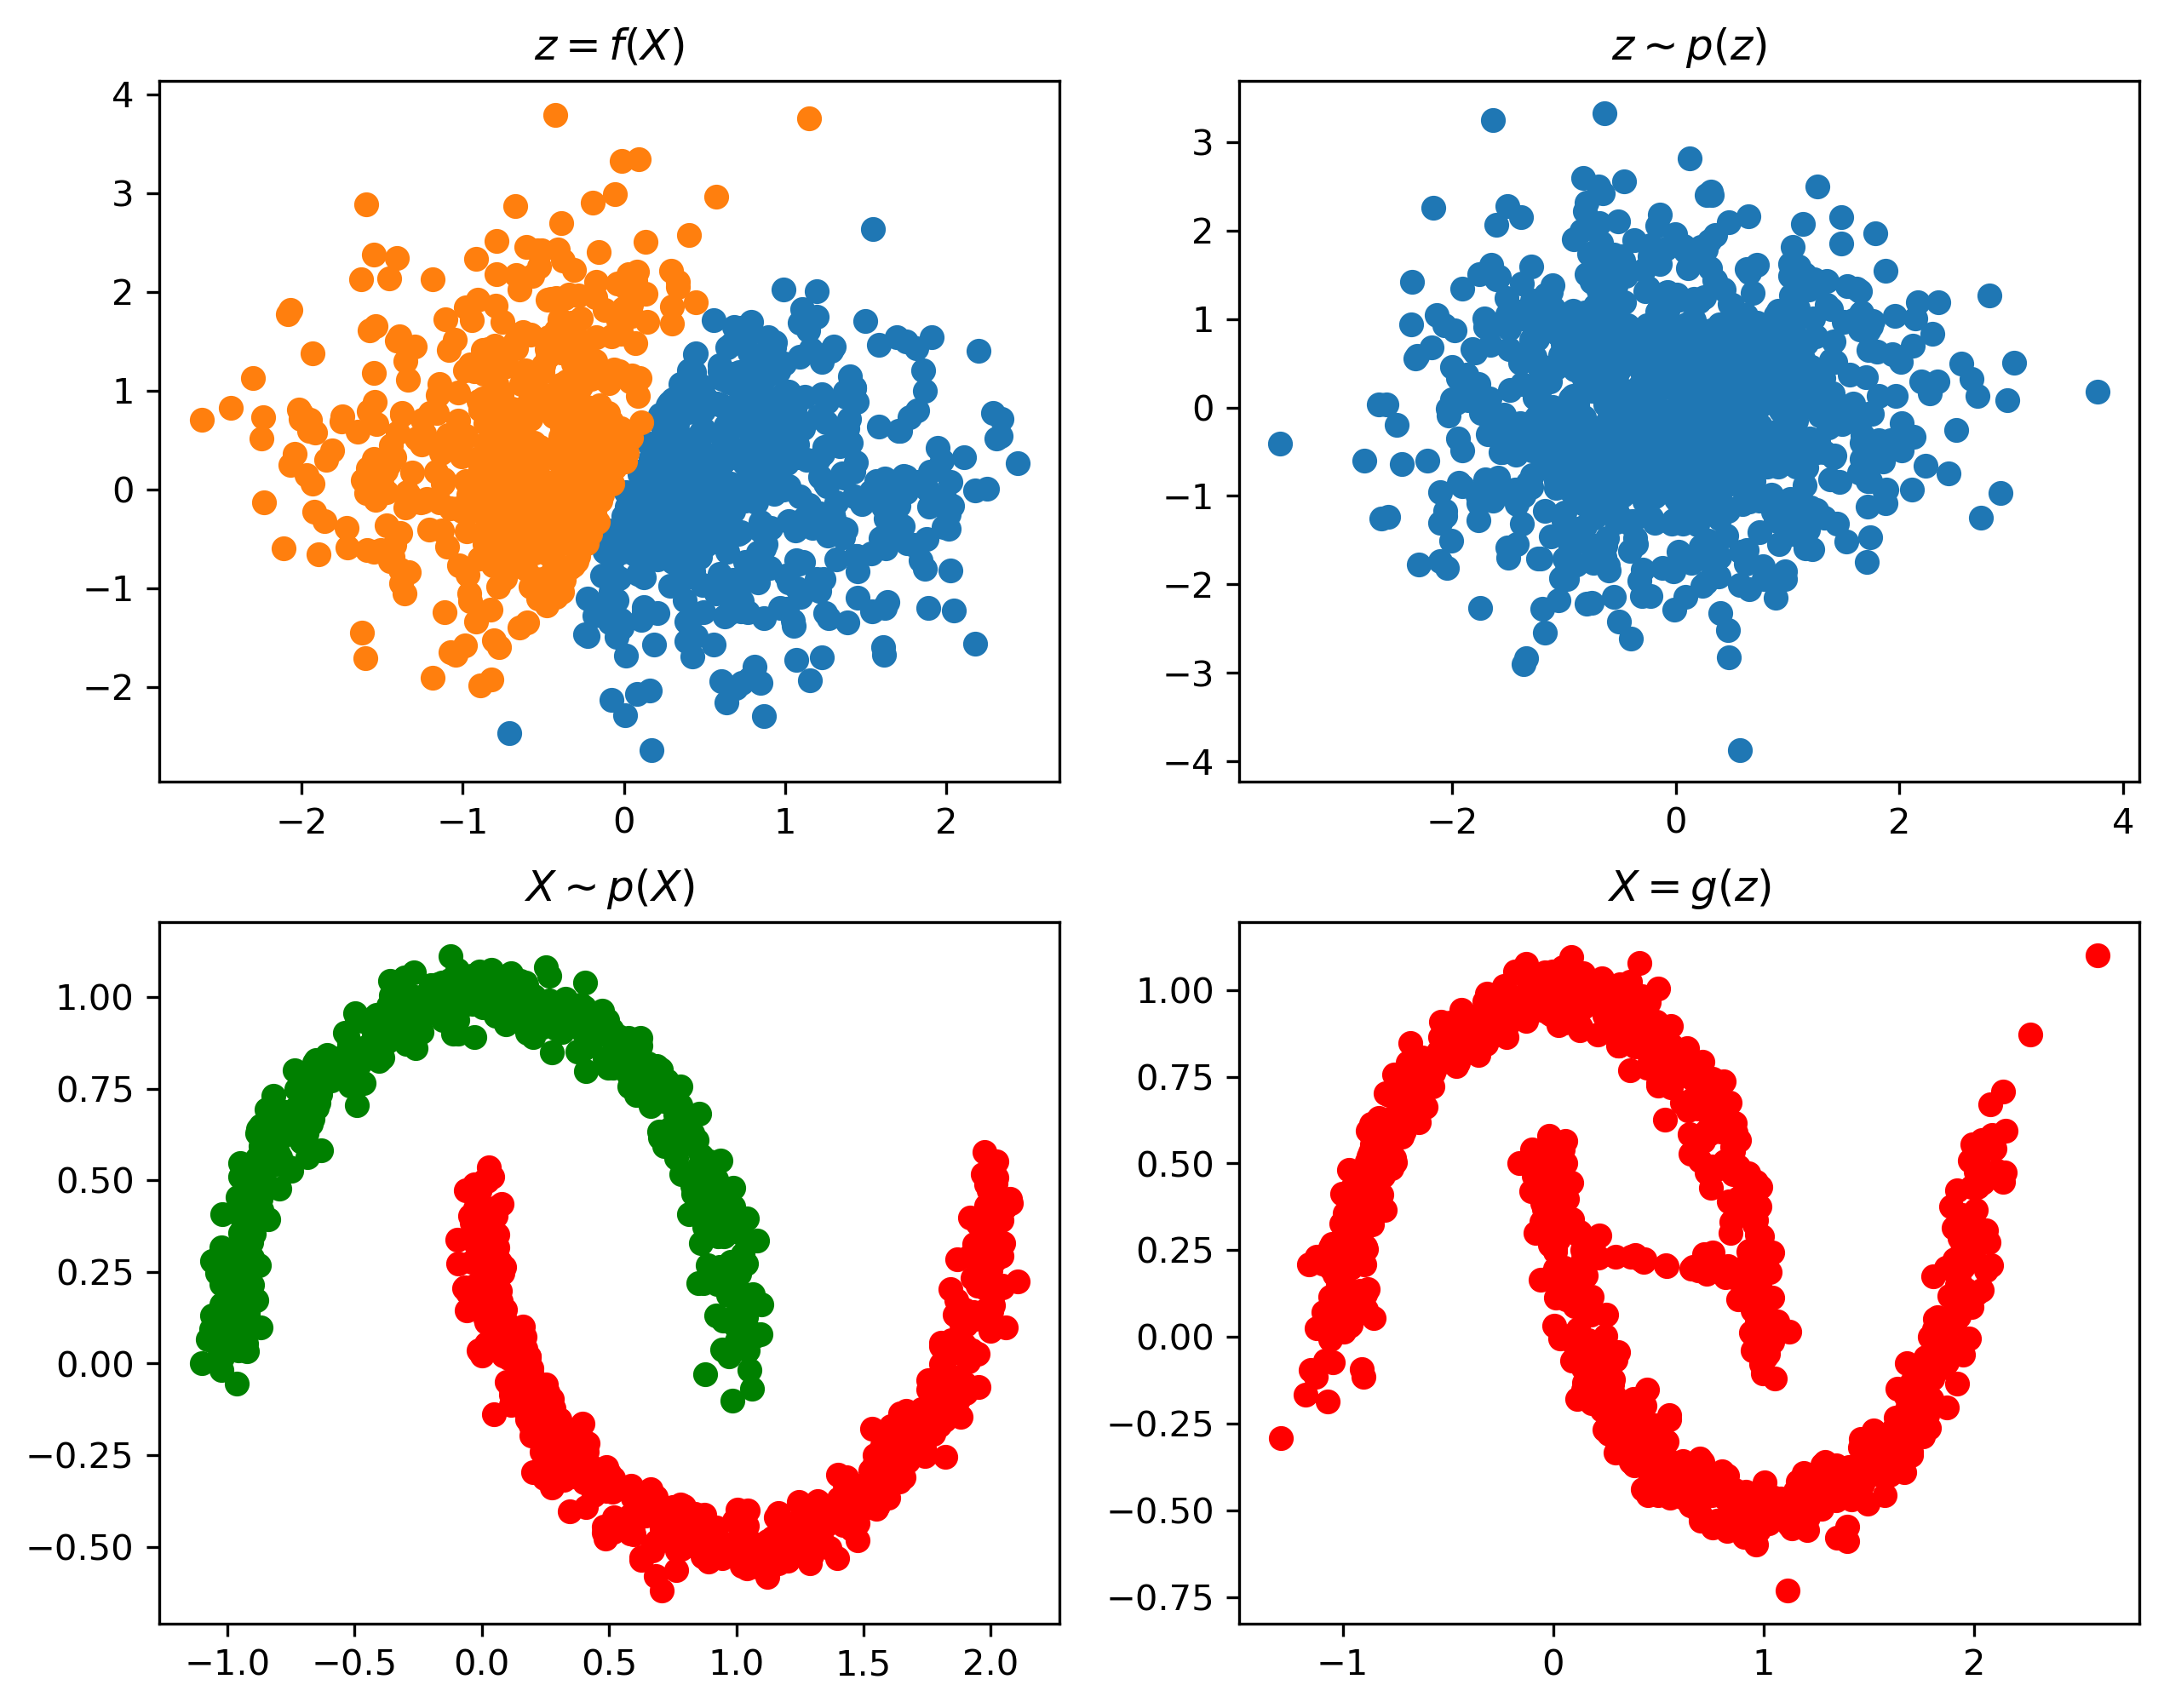

In [5]:
noisy_moons, label = datasets.make_moons(n_samples=1000, noise=.05)
label = label.astype(bool)
z = flow.f(torch.from_numpy(noisy_moons.astype(np.float32)))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[label, 0], z[label, 1])
plt.scatter(z[~label, 0], z[~label, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x, y = datasets.make_moons(n_samples=1000, noise=.05)
x = x.astype(np.float32)
y = y.astype(bool)
plt.scatter(x[y, 0], x[y, 1], c='r')
plt.scatter(x[~y, 0], x[~y, 1], c='g')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000)[0].detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')